# Please **DO NOT** run any cells as everything (all final images, graphs, etc. are preloaded)

# Section 0 - Preface for Imports, Data Handling, & Methodologies 

## Section 0.1 Preface for Write-Up Interpretation

For the remainder of this notebook, each part 1) and 2) will be answered in line with notation for the following block of code to show:

1. A brief statement (~paragraph) of what was done to answer the question (narratively explaining what you did in code to answer the question, at a high level).

2. A brief statement (~paragraph) as to why this was done (why the question was answered in this way, not by doing something else. Some kind of rationale as to why you did x and not y or z to answer the question – why is what you did a suitable approach?).

For 3) and 4) the findings and interpretations will be provided in Results & Discussions for each question (model(s)) we ran.

## Section 0.2 Imports & Installation of Packages and Libraries

In [1]:
%pip install eli5
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time

import numpy as np
import pandas as pd
import torch

import scipy.stats as st

# import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler as sc
from sklearn.model_selection import train_test_split, cross_validate, KFold, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn import tree, ensemble, metrics, calibration
from sklearn.svm import SVC, LinearSVC

from eli5.sklearn import PermutationImportance
import eli5

from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from skopt import BayesSearchCV

from tune_sklearn import TuneSearchCV, TuneGridSearchCV
import ray.tune as tune

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import scikitplot as skplt
import seaborn as sns; sns.set_theme(color_codes=True)
import graphviz
import colorcet as cc

## Section 0.3

Checking the availability of CUDA for PyTorch on this Device and if available, use it for Gradient Descent

In [2]:
print(f'CUDA is Available: {torch.cuda.is_available()}')
print(f'Current CUDA Device: {torch.cuda.current_device()}')
print(f'CUDA Device Location: {torch.cuda.device(0)}')
print(f'CUDA Device Count: {torch.cuda.device_count()}')
print(f'CUDA Device Name: {torch.cuda.get_device_name(0)}, {torch.cuda.get_device_name(1)}')

CUDA is Available: True
Current CUDA Device: 0
CUDA Device Location: <torch.cuda.device object at 0x000001616B63CE80>
CUDA Device Count: 2
CUDA Device Name: NVIDIA TITAN RTX, NVIDIA TITAN RTX


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')
print(f'Currently Using Device: {device}')

Currently Using Device: cuda:0


## Section 0.4 Data Handling

Below, we check the presence of `NA`'s in the dataframe and afterwards, output a description of the dataframe, including `'all'` columns

In [4]:
df = pd.read_csv('diabetes.csv')

print(f'Dataframe contains any NA values: {df.isnull().values.any()}')
df.describe(include='all')

Dataframe contains any NA values: False


,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.084177,2.511392,3.184772,4.242081,0.168224,1.440342,8.032119,5.050434,6.053875,6.504380
std,0.346294,0.494934,0.494210,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148,3.453446
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,6.000000,4.000000,5.000000,4.000000
50%,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,8.000000,5.000000,7.000000,7.000000
75%,0.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,2.000000,10.000000,6.000000,8.000000,10.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,2.000000,13.000000,6.000000,8.000000,12.000000


Viewing the entries of the first 10 rows of the dataframe:

In [28]:
df.head(10)

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,...,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,1,11,5,4,8
5,0,1,1,25,1,0,0,1,1,1,...,0,2,0,2,0,2,10,6,8,2
6,0,1,0,30,1,0,0,0,0,0,...,0,3,0,14,0,1,9,6,7,4
7,0,1,1,25,1,0,0,1,0,1,...,0,3,0,0,1,1,11,4,4,7
8,1,1,1,30,1,0,1,0,1,1,...,0,5,30,30,1,1,9,5,1,12
9,0,0,0,24,0,0,0,0,0,1,...,0,2,0,0,0,2,8,4,3,12


## Section 0.5 Standardization & Normalization

Each question will pertain to a different method of standardization & normalization, for example Question 1 (a logistic regression) does not require this (the regression itself is not sensitive to the magnitude of variables). I will specify the particulates prefaced for each question. 

### Extract the first column as the label

In [6]:
label = df[['Diabetes']]
label

,Diabetes
0,0
1,0
2,0
3,0
4,0
...,...
253675,0
253676,1
253677,0
253678,0


### View a correlation matrix of the data

In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(10)

C:\Users\sunny\AppData\Local\Temp\ipykernel_27868\3389594757.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(10)


,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,HeavyDrinker,HasHealthcare,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
Diabetes,1.0000000000,0.2631287899,0.2002761919,0.2168430602,0.0607885056,0.1058160673,0.1772822578,-0.1181331149,-0.0407792281,-0.0565841371,-0.0570562561,0.0162551395,0.0314327634,0.2935690631,0.0693150826,0.1713367004,0.2183443519,0.0314299980,0.1774418722,-0.1244559692,-0.1639187868,-0.0001971111
HighBP,0.2631287899,1.0000000000,0.2981992951,0.2137481202,0.0969914670,0.1295749130,0.2093612107,-0.1252668662,-0.0405546586,-0.0612661653,-0.0039715740,0.0384247689,0.0173579836,0.3005296306,0.0564559169,0.1612115712,0.2236184659,0.0522069607,0.3444523298,-0.1413579336,-0.1712345812,-0.0026294552
HighChol,0.2002761919,0.2981992951,1.0000000000,0.1067220822,0.0912993573,0.0926200745,0.1807653549,-0.0780461859,-0.0408590813,-0.0398736072,-0.0115425186,0.0422298622,0.0133101632,0.2084255497,0.0620691538,0.1217505276,0.1446715380,0.0312053301,0.2723182263,-0.0708018870,-0.0854593146,0.0010516002
BMI,0.2168430602,0.2137481202,0.1067220822,1.0000000000,0.0138044667,0.0201526605,0.0529042565,-0.1472936336,-0.0875181207,-0.0622751936,-0.0487362755,-0.0184707866,0.0582062901,0.2391853727,0.0853101592,0.1211411074,0.1970777603,0.0429503033,-0.0366176352,-0.1039320221,-0.1000687103,-0.0019316871
Smoker,0.0607885056,0.0969914670,0.0912993573,0.0138044667,1.0000000000,0.0611726747,0.1144412177,-0.0874011625,-0.0776658386,-0.0306777098,0.1016186870,-0.0232508032,0.0489458235,0.1631430671,0.0921964744,0.1164597144,0.1224632146,0.0936623614,0.1206410845,-0.1619552554,-0.1239372292,0.0009745959
Stroke,0.1058160673,0.1295749130,0.0926200745,0.0201526605,0.0611726747,1.0000000000,0.2030019400,-0.0691514156,-0.0133893530,-0.0411242247,-0.0169503303,0.0087759254,0.0348041063,0.1779422602,0.0701718117,0.1489441689,0.1765669170,0.0029782884,0.1269736985,-0.0760085572,-0.1285985781,-0.0019328208
Myocardial,0.1772822578,0.2093612107,0.1807653549,0.0529042565,0.1144412177,0.2030019400,1.0000000000,-0.0872989869,-0.0197903479,-0.0391674090,-0.0289905157,0.0187341863,0.0309997048,0.2583834087,0.0646212920,0.1816975358,0.2127086953,0.0860955081,0.2216176324,-0.0995999154,-0.1410112314,-0.0012315553
PhysActivity,-0.1181331149,-0.1252668662,-0.0780461859,-0.1472936336,-0.0874011625,-0.0691514156,-0.0872989869,1.0000000000,0.1427558627,0.1531495702,0.0123922362,0.0355047365,-0.0616383873,-0.2661856237,-0.1255870881,-0.2192295222,-0.2531740075,0.0324816858,-0.0925106333,0.1996580572,0.1985394551,-0.0008418517
Fruit,-0.0407792281,-0.0405546586,-0.0408590813,-0.0875181207,-0.0776658386,-0.0133893530,-0.0197903479,0.1427558627,1.0000000000,0.2543422444,-0.0352877329,0.0315439188,-0.0442426894,-0.1038541713,-0.0682173751,-0.0446333245,-0.0483516746,-0.0911748653,0.0645472165,0.1101870969,0.0799293134,-0.0022553916
Vegetables,-0.0565841371,-0.0612661653,-0.0398736072,-0.0622751936,-0.0306777098,-0.0411242247,-0.0391674090,0.1531495702,0.2543422444,1.0000000000,0.0210644811,0.0295838169,-0.0322317050,-0.1230663300,-0.0588835533,-0.0642903271,-0.0805057167,-0.0647651561,-0.0097711976,0.1543292615,0.1510869442,-0.0007323915


## Section 0.6 Label View

In this section, we will view the output of the labels and take into account disparity in outcome.

We can see from the outcome that the classes are highly skewed to the negative and would require the use of f1 scores to disting predictive capability under this skewness.

In [8]:
one_count = len(label.loc[(label['Diabetes'] == 1)])
zero_count = len(label.loc[(label['Diabetes'] == 0)])
print(f'Number of positive class: {one_count}')
print(f'Number of negative class: {zero_count}')

Number of positive class: 35346
Number of negative class: 218334


# Question 1

Build a logistic regression model. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

## Answer

## Section 1.0 `LogisticRegression()` Fitting & Train-Test Split

Again in reference to §0.2 of the Preface, I will **NOT** be normalizing/standardizing for this question, due to logistic regression being robust to the magnitude of the variables.[<sup>[1]</sup>](#fn1) Below I included code of the Scikit-Learn library I utilized to create the logistic regression model, as well as any outputs.

We will then use the Scikit-Learn Module `train_test_split` to create a split dataset of 0.3 proportional size for the test set, as well as using the `random_state` equalling `1234`. This is to cross-validate the model and ensure generalizability. 

In [9]:
X = df.loc[:, 'HighBP':]
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

## Section 1.1 `LogisticRegression()` Obtaining Accuracy, Predicted Values, and Predicted Probabilities

Using each `clf_score`, `clf_predict`, and `clf_proba` we find the values of accuracy, predicted values, and class probability predictions for the logistic regression model. 

Implementation involved utilizing the `sklearn` package for `LogisticRegression` as well as the involved methods for the aforementioned values. I chose this over other packages given its simplicity and explanability of attributes as well as useful methods.

In [7]:
clf_logistic = LogisticRegression().fit(X_train,y_train)

clf_coefs = clf_logistic.coef_[0]

clf_score = clf_logistic.score(X_test, y_test)
clf_predict = clf_logistic.predict(X_test) # This also equals y_hat
clf_proba = clf_logistic.predict_proba(X_test)[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Section 1.2 `LogisticRegression()` Individual AUC Curves From Individual Predictors

In this section, we create AUC curves from each of all individual predictors of logistic regression. This analysis will be considered at then end when determining the best predictor.

For this section, I used `train_test_split` to split the data for cross validation, `LogisticRegression` for the model, and `metrics` as well as `auc` for the AUC curve and AUC ROC (all from `sklearn`) as well as subplots from `seaborn` to create graphs representing the ROC Curves of a model made from each predictor as a singular variable against the outcome (label).

This was done to show the efficacy of each predictor (to find the best predictor) by individually testing for the performance of a model created through a singular predictor in terms of a degree of separability. I did explore alternatives later on to show for performance when accounting for colinearity (by creating a full model and interpreting $\beta$'s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

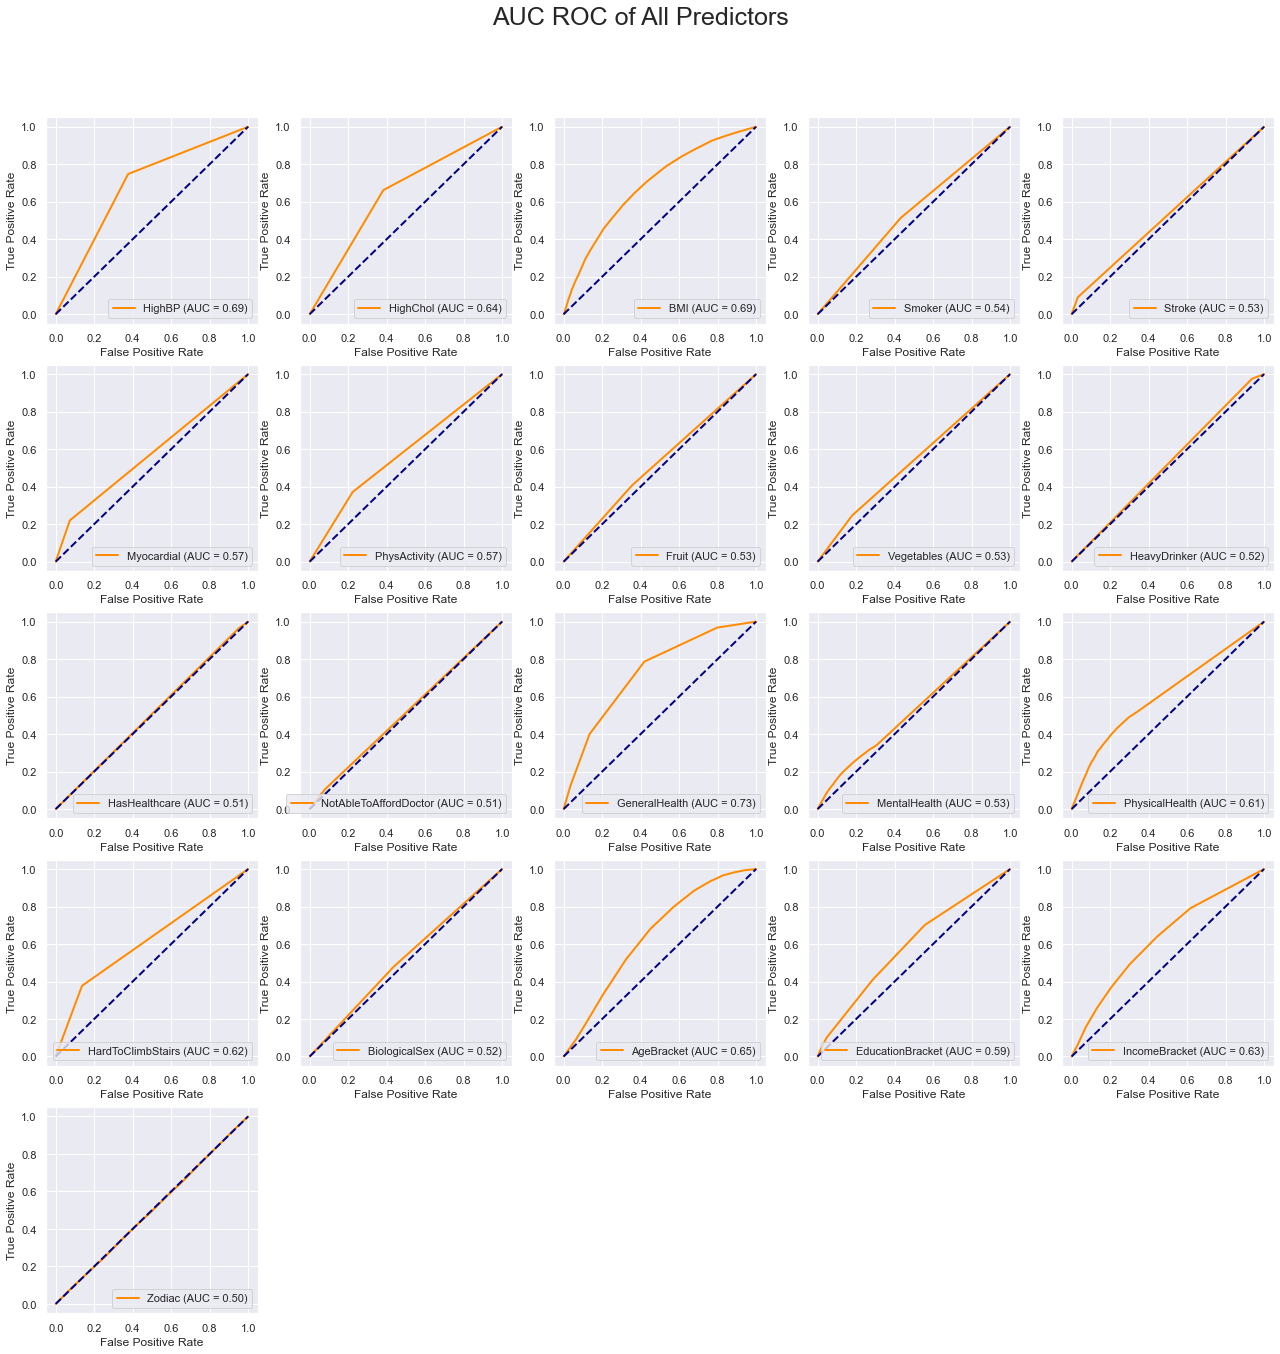

In [12]:
predictors = df.iloc[:,1:]
pred_auc = []

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(22,22))
fig.suptitle('AUC ROC of All Predictors', fontsize=25, y=0.95)
axs[4,1].set_visible(False)
axs[4,2].set_visible(False)
axs[4,3].set_visible(False)
axs[4,4].set_visible(False)

for pred, ax in zip(predictors, axs.ravel()):
    
    x_train, x_test, y_train, y_test = train_test_split(predictors[[pred]], label, test_size=0.3, random_state=1234)

    logreg = LogisticRegression().fit(x_train, y_train)
    pred_proba = logreg.predict_proba(x_test)[:,1]
    
    fpr, tpr, _ = metrics.roc_curve(y_true=y_test, y_score=pred_proba, pos_label=1)
    auc = metrics.auc(x=fpr, y=tpr)

    pred_auc.append(auc)
    
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc,
                                      estimator_name=f'{pred}')
    display.plot(color='darkorange', lw=2, ax=ax)
    ax.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")

We see the sorted `auc` column by the score of AUC and find that `GeneralHealth` has the highest at 0.728133.

In [13]:
columns = X.columns

df_auc = pd.DataFrame(data=columns, columns=['predictors'])
df_auc['auc'] = pred_auc
df_auc.sort_values(by='auc', inplace=True, ascending=False)
df_auc

,predictors,auc
12,GeneralHealth,0.728133
2,BMI,0.687248
0,HighBP,0.685702
17,AgeBracket,0.646766
1,HighChol,0.639535
19,IncomeBracket,0.629339
15,HardToClimbStairs,0.620154
14,PhysicalHealth,0.610386
18,EducationBracket,0.590881
6,PhysActivity,0.574052


## Section 1.3 $\beta$'s of `LogisticRegression()` & Interpretation

What follows is a dataframe containing all of the $\beta$'s of the logistic regression/classifier model we previously ran (each $\beta$ being the log odds), alongside $e^{\beta}$ of the coefficients to determine the odds of each predictor.

This was done to show the importance of each predictor, when accounting for colinearity. By creating a model with all of the predictors, we are able to find the predictor most important to the full-model used later that incorporates colinearity within the model. All of this was implemented with the built-in attributes of `.coefs_` within the `LocisticRegression` method within `sklearn`

This was done as a potential alternative to the individual AUC model ran previously, that only showed the efficacy of individual predictors but not in consideration of the entire model.

In [14]:
columns = X.columns

## Sanity check to make sure column labels and coefficients match up
assert columns.shape == clf_coefs.shape, 'Should be Equal'

df_coefs = pd.DataFrame(columns, columns = ['predictors'])
df_coefs['ln_odds'] = clf_coefs
df_coefs['odds'] = np.exp(clf_coefs)
df_coefs.sort_values(by='odds', inplace=True, ascending=False)


print(f'Model Score: {clf_score:.6f}')

df_coefs

Model Score: 0.859127


,predictors,ln_odds,odds
0,HighBP,0.882521,2.416986
1,HighChol,0.648162,1.912023
12,GeneralHealth,0.506093,1.658798
5,Myocardial,0.361496,1.435475
4,Stroke,0.194176,1.214310
15,HardToClimbStairs,0.170770,1.186218
16,BiologicalSex,0.132674,1.141878
17,AgeBracket,0.077928,1.081045
2,BMI,0.048233,1.049415
13,MentalHealth,-0.005645,0.994371


## Section 1.4 `LogisticRegression()` Confusion Matrix

Below we plot the confusion matrix for the logistic regression we just created.

This was done using the `sklearn` package `plot_confusion_matrix`.

No other alternative method seemed plausible, and a confusion matrix was plotted to show Predicted Labels against True Labels and therefore shows the correct/incorrect predicted values broken down by class.

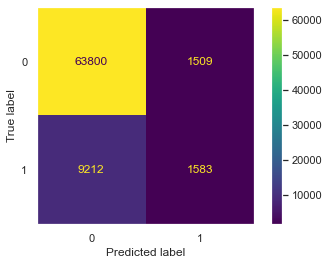

In [15]:
metrics.plot_confusion_matrix(estimator=clf_logistic, X=X_test, y_true=y_test)
plt.grid(False)

## Section 1.5 `LogisticRegression()` AUC ROC

Below we calculate the AUR ROC as well as the accompanying graph of the full logistic regression model using the `sklearn` package and `RocCurveDisplay` to do so.

This was done to fulfill the requirement set forth in the Spec Sheet as well as to show the classification capability of our model to distinguish between $TPR = \frac{TP}{TP + TN}$ and $FPR = 1 - \frac{TN}{TN + FP} = \frac{FP}{FP + TN}$. 

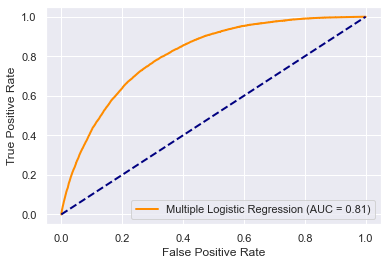

In [16]:
fpr, tpr, thresh = metrics.roc_curve(y_true=y_test, y_score=clf_proba, pos_label=1)
logreg_auc = metrics.auc(x=fpr, y=tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=logreg_auc,
                                  estimator_name='Multiple Logistic Regression')

display.plot(color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

## Section 1.6 `LogisticRegression()` Test Accuracy Scores

Below we show the `accuracy`, `precision`, `recall`, and `f1` scores found using `accuracy_score` and `precision_recall_fscore_support` all from `sklearn`.

This was done to determine the predictive capability against false positives and false negatives in the model (by accounting for model imbalance) of output classes by taking the harmonic mean of percision and recall.

In [17]:
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=clf_predict)
others = metrics.precision_recall_fscore_support(y_true=y_test, y_pred=clf_predict, average='binary')

logistic_metrics =  {'accuracy': accuracy,
                     'precision': others[0],
                     'recall': others[1],
                     'f1': others[2]}

logistic_metrics

{'accuracy': 0.8591269841269841,
 'precision': 0.5119663648124192,
 'recall': 0.14664196387216305,
 'f1': 0.2279830056887737}

## Section 1.7 Results & Discussion

Interpreting above, we can see that in the findings for our model,

* Accuracy = 0.859127

* Furthermore, the odds ($e^{\beta}$) of `HighBP` is around 2.417

* And the single, individual predictor with the highest AUC ROC is `GeneralHealth` at 0.7281

* I also included a f1 score to highlight the ability to predict false positives and false negatives from the imbalanced data (shown in §0.6) which was 0.227983.

* Lastly, the AUR ROC for the entire model is around 0.81 for the test set, meaning the logistic classifier is much better at discriminating between postive and negative classes than a random choice of classes.

I then interpret the outputs as:

* From the accuracy and f1 scores, we see that our model predicts around 0.86 of all classes accurately, but from the f1 that the model is less robust in predicting in terms of the biased number of classes (such as in this dataset).

* In terms of ($e^{\beta}$)'s accounting for colinearity we see that `HighBP` is highest, but we must contrast this with our result of highest single predictor AUC ROC `GeneralHealth` being the highest. In terms of the report question, I would choose the result from the individual AUC ROC's `GeneralHealth`. This is due to Professor Pascal's own advice and culpabilities in further analysis outside the scope of this report taht can decrease colinearity.

* The AUC of the entire model is plotted and stated previously (§1.5). At 0.81, it is able to better distinguish true positives and true negatives than random guessing.

# Question 2

Build a SVM. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

## Answer

## Section 2.0 `LinearSVC()` Train-Test Split to Classifier

Accordingly with the previous question, we initiate a `train_test_split` with `test_size = 0.3` and `random_state = 1234`to cross validate results, and ensure predictive capability in action.

In [15]:
X = df.loc[:, 'HighBP':]
y = label

print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

Shape of X:  (253680, 21)
Shape of y:  (253680, 1)


## Section 2.1 `LinearSVC()` Initialization & Tuning

We will then initialize a `LinearSVC()` classifier from `sklearn` using the optimal hyperparameters defined in our `TuneSearchCV` hyperparameter search.

This was done to regularize the model and create a soft margin classifier, maximizing the slack variable `C` but minimizing for `squared_hinge` ($L_{2}$ norm).

### Note: **DO NOT** run these following lines of code, as the fitting for this specific `LinearSVC` takes more than an hour.

In [22]:
params = {'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0]}

tune_SVC = TuneGridSearchCV(estimator=LinearSVC(), refit=True, verbose=1, n_jobs=-1,
                            use_gpu=True, return_train_score=True, param_grid=params)

In [23]:
start = time.time()
tune_SVC.fit(X_train, y_train) ## Commented out due to running Ray-Tune and already finging the optimal hyperparameters
end = time.time()
print("Tune RandomSearch Fit Time:", end - start)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Tune RandomSearch Fit Time: 3732.7026147842407


## Section 2.2 `LinearSVC()` Fitting Optimal Classifier & Calibration For Probability Prediction

We then create a new `LinearSVC()` classifier with the optimal `C` variable we found from hyperparameter tuning previously. From there, we instantiate a `CalibratedClassifierCV` class to predict sample outcomes with.

This was done in accordance with the `sklearn` and `raytune` workflow program for hyperparameter tuning a model, fitting the optimal classifier, and outputting predictions (`LinearSVC()` does not normally allow for probability prediction, but this can be done with `CalibratedClassifierCV` and the parameter call for Platt scaling).

In [55]:
opt_SVC = LinearSVC(C=0.09)

start = time.time()
opt_SVC.fit(X_train, y_train)
end = time.time()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=0.09)

In [56]:
cal_SVC = calibration.CalibratedClassifierCV(base_estimator=opt_SVC, method='sigmoid', n_jobs=-1, cv='prefit')
cal_SVC.fit(X_test, y_test)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.09), cv='prefit', n_jobs=-1)

In [57]:
SVC_proba = cal_SVC.predict_proba(X_test)[:,1]
SVC_pred = cal_SVC.predict(X_test)

## Section 2.3 `LinearSVC()` Permutation Importance

To show the most important predictor, we use the `sklearn.inspection.permutation_importance` package in order to calculate the permutation importance of all features (the difference between the baseline metric and metric from permuting a drop in the feature column).[<sup>[4]</sup>](#fn4)[<sup>[5]</sup>](#fn5)

This was done to shuffle the rows of every feature, cross validate over 5-folds, and determine the features attributed to the largest drop in performance (which we will determine as most important) and the features attributed to the largest boost in performance (attributed as the least).

In [ ]:
perm_importance = permutation_importance(estimator=opt_SVC, n_repeats=3, X=X_test, y=y_test, n_jobs=64)

feature_names = X.columns
sort_idx = perm_importance.importances_mean.argsort()

data_df = pd.DataFrame(data=[feature_names[sort_idx], perm_importance.importances_mean[sort_idx]], columns=['Features', 'Importance'], palette='Blues_d', ci=None)

plot = sns.barplot(x='Features', y='Importance', data=data_df)

Unfortunately, the previous method is far too slow to implement.

In using the `eli5` package `PermutationImportance` we are able to do the same as the `sklearn` package, by permuting every feature and determining the importance of each feature by the effect it has on the model. As previously, the rows of every feature is shuffled and cross validate over 5-fold, and determine the features attributed to the largest drop in performance (which we will determine as most important) and the features attributed to the largest boost in performance (attributed as the least).

In [58]:
perm = PermutationImportance(estimator=opt_SVC, random_state=1234)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0036 ± 0.0004,BMI
0.0027 ± 0.0002,GeneralHealth
0.0014 ± 0.0005,HighBP
0.0013 ± 0.0003,HighChol
0.0006 ± 0.0005,AgeBracket
0.0006 ± 0.0001,Myocardial
0.0006 ± 0.0001,HardToClimbStairs
0.0004 ± 0.0001,IncomeBracket
0.0002 ± 0.0001,EducationBracket
0.0001 ± 0.0001,HeavyDrinker


## Section 2.4 `LinearSVC()` Confusion Matrix

Below we plot the confusion matrix for the logistic regression we just created.

This was done using the `sklearn` package `plot_confusion_matrix`.

No other alternative method seemed plausible, and a confusion matrix was plotted to show Predicted Labels against True Labels and therefore shows the correct/incorrect predicted values broken down by class.

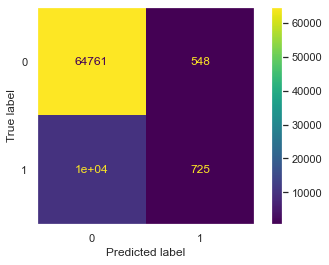

In [59]:
metrics.plot_confusion_matrix(estimator = opt_SVC, X = X_test, y_true = y_test)
plt.grid(False)

## Section 2.5 `LinearSVC()` AUC ROC

Below we calculate the AUR ROC as well as the accompanying graph of the full logistic regression model using the `sklearn` package and `RocCurveDisplay` to do so.

This was done to fulfill the requirement set forth in the Spec Sheet as well as to show the classification capability of our model to distinguish between $TPR = \frac{TP}{TP + TN}$ and $FPR = 1 - \frac{TN}{TN + FP} = \frac{FP}{FP + TN}$. 

0.8179993279676036


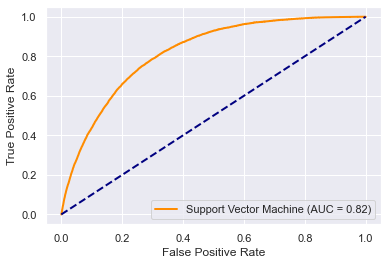

In [60]:
fpr, tpr, thresh = metrics.roc_curve(y_true=y_test, y_score=SVC_proba, pos_label=1)
svc_auc = metrics.auc(x=fpr, y=tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=svc_auc,
                                  estimator_name='Support Vector Machine')

print(svc_auc)
display.plot(color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

## Section 2.6 `LinearSVC()` Test Accuracy Scores

Below we show the `accuracy`, `precision`, `recall`, and `f1` scores found using `accuracy_score` and `precision_recall_fscore_support` all from `sklearn`.

This was done to determine the predictive capability against false positives and false negatives in the model (by accounting for model imbalance) of output classes by taking the harmonic mean of percision and recall.

In [61]:
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=SVC_pred)
others = metrics.precision_recall_fscore_support(y_true=y_test, y_pred=SVC_pred, average='binary')

adaboost_metrics =  {'accuracy': accuracy,
                     'precision': others[0],
                     'recall': others[1],
                     'f1': others[2]}

adaboost_metrics

{'accuracy': 0.8602570167139704,
 'precision': 0.5251256281407035,
 'recall': 0.15488652153774896,
 'f1': 0.2392159668073539}

## Section 2.7 Results & Discussion

Interpreting above, we can see that in the findings for our Support Vector Machine model,

* Accuracy = 0.860257

* And the single, individual predictor with the highest `PermutationImportance = 0.0036 ± 0.0004` is `BMI`

* I also included a f1 score to highlight the ability to predict false positives and false negatives from the imbalanced data (shown in §0.6) which was 0.239216

* Lastly, the AUR ROC for the entire model is around 0.82 for the test set, meaning the logistic classifier is much better at discriminating between postive and negative classes than a random choice of classes.

I then interpret the outputs as:

* From the accuracy and f1 scores, we see that our model predicts around 0.86 of all classes accurately, but from the f1 that the model is less robust in predicting in terms of the biased number of classes (such as in this dataset).

* From `PermutationImportance` we see that, by shuffling the indices of each feature column and repeating this 5-fold for each column, we obtain `BMI` as the most important (best) predictor

* The AUC of the entire model is plotted and stated previously (§1.5). At 0.818, it is able to better distinguish true positives and true negatives than random guessing.

# Question 3

Use a single, individual decision tree. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

## Answer

## Section 3.0 `DecisionTreeClassifier()` Train-Test Split to Classifier

Accordingly with previous questions, we initiate a `train_test_split` with `test_size = 0.3` and `random_state = 1234`to cross validate results, and ensure predictive capability in action

In [6]:
X = df.loc[:, 'HighBP':]
y = label

print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

Shape of X:  (253680, 21)
Shape of y:  (253680, 1)


## Section 3.1 `DecisionTreeClassifier()` Initialization and Fitting

Initialize and fit the `DecisionTreeClassifier` to the data then calculate the probabilities of each `X_test` sample and class predictions for that test set.

This was done to create the model, and make it posible to make the model useful through prediction.

In [7]:
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

treeclf_proba = tree_clf.predict_proba(X_test)[:,1]
treeclf_pred = tree_clf.predict(X_test)

DecisionTreeClassifier()

## Section 3.2.1 `DecisionTreeClassifier()` Tree Graph Using Graphviz

Create tree-graph and save as PDF. This was done initially to provide imagery for the output, but in retrospect became a nuisance due to the large format (22 predictors) of the output image and was not used.

In [25]:
path = 'C:/Program Files/Graphviz/bin/'

os.environ['PATH'] += os.pathsep + path ## Adds the program file to PATH, requires download of graphviz from link below (Citation [6])

In [26]:
dot_data = tree.export_graphviz(tree_clf, out_file=None,
                                feature_names=X_test.columns,
                                class_names=y_train.columns[0], # Requires a string input, y_train.columns returns an Index object
                                filled=True, rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dot_data)
graph

## Section 3.31 `DecisionTreeClassifier()` Feature Importance

Below we used the `feature_importances_` attribute of the `DecisionTreeClassifier()` class to determine the importance of features.

This was done to show the accumulation of impurity decrease with each successive node layer, and thus the first layer (by the definition of our model to having gini score decrease as the objective function) would have the highest gini impurity decrease, and thus being the "best predictor." 

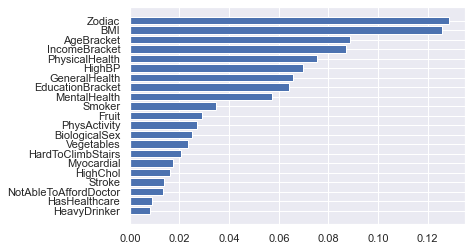

In [32]:
importances = tree_clf.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

## Section 3.3.2 `DecisionTreeClasifier()` Permutation Importance

In using the `eli5` package `PermutationImportance` we are able to do the same as the `sklearn` package, by permuting every feature and determining the importance of each feature by the effect it has on the model. As previously, the rows of every feature is shuffled and cross validate over 5-fold, and determine the features attributed to the largest drop in performance (which we will determine as most important) and the features attributed to the largest boost in performance (attributed as the least).

In [34]:
perm = PermutationImportance(estimator=tree_clf, random_state=1234)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0162 ± 0.0027,GeneralHealth
0.0087 ± 0.0028,AgeBracket
0.0082 ± 0.0022,BMI
0.0049 ± 0.0010,PhysicalHealth
0.0039 ± 0.0014,HighChol
0.0033 ± 0.0012,MentalHealth
0.0031 ± 0.0003,HardToClimbStairs
0.0029 ± 0.0017,IncomeBracket
0.0024 ± 0.0006,HighBP
0.0023 ± 0.0006,Myocardial


## Section 3.4 `DecisionTreeClassifier()` Confusion Matrix

Below we plot the confusion matrix for the logistic regression we just created.

This was done using the `sklearn` package `plot_confusion_matrix`.

No other alternative method seemed plausible, and a confusion matrix was plotted to show Predicted Labels against True Labels and therefore shows the correct/incorrect predicted values broken down by class.

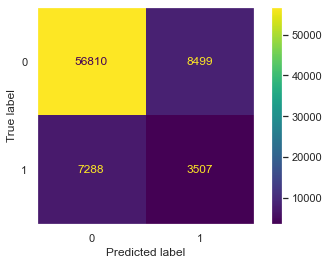

In [9]:
metrics.plot_confusion_matrix(estimator = tree_clf, X = X_test, y_true = y_test)
plt.grid(False)

## Section 3.5 `DecisionTreeClassifier()` AUC ROC

Below we calculate the AUR ROC as well as the accompanying graph of the full logistic regression model using the `sklearn` package and `RocCurveDisplay` to do so.

This was done to fulfill the requirement set forth in the Spec Sheet as well as to show the classification capability of our model to distinguish between $TPR = \frac{TP}{TP + TN}$ and $FPR = 1 - \frac{TN}{TN + FP} = \frac{FP}{FP + TN}$. 

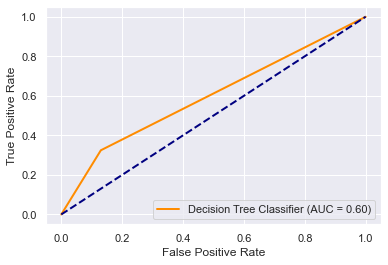

In [10]:
fpr, tpr, thresh = metrics.roc_curve(y_true=y_test, y_score=treeclf_proba, pos_label=1)
dectree_auc = metrics.auc(x=fpr, y=tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=dectree_auc,
                                  estimator_name='Decision Tree Classifier')

display.plot(color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

## Section 3.6 `DecisionTreeClassifier()` Test Accuracy Scores

Below we show the `accuracy`, `precision`, `recall`, and `f1` scores found using `accuracy_score` and `precision_recall_fscore_support` all from `sklearn`.

This was done to determine the predictive capability against false positives and false negatives in the model (by accounting for model imbalance) of output classes by taking the harmonic mean of percision and recall.

In [12]:
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=treeclf_pred)
others = metrics.precision_recall_fscore_support(y_true=y_test, y_pred=treeclf_pred, average='binary')

dt_metrics =  {'accuracy': accuracy,
                     'precision': others[0],
                     'recall': others[1],
                     'f1': others[2]}

dt_metrics

{'accuracy': 0.792560180805214,
 'precision': 0.292103948025987,
 'recall': 0.3248726262158407,
 'f1': 0.30761808692601206}

## Section 3.7 Results & Discussion

Interpreting above, we can see that in the findings for our Decision Tree Classifier model,

* Accuracy = 0.79256018

* The single, individual predictor with the highest `PermutationImportance = 0.0162 ± 0.0027` is `GeneralHealth`

* The single, individual predictor with the highest `feature_importances_` importance (highest gini-impurity decrease) is `Zodiac`

* I also included a f1 score to highlight the ability to predict false positives and false negatives from the imbalanced data (shown in §0.6) which was 0.307618

* Lastly, the AUR ROC for the entire model is around 0.60 for the test set, meaning the logistic classifier is slightly better at discriminating between postive and negative classes than a random choice of classes (greater than 0.5 but not by much).

I then interpret the outputs as:

* From the accuracy and f1 scores, we see that our model predicts around 0.79 of all classes accurately, but from the f1 that the model is less robust in predicting in terms of the biased number of classes (such as in this dataset).

* From `PermutationImportance` we see that, by shuffling the indices of each feature column and repeating this 5-fold for each column, we obtain `GeneralHealth` as the most important (best) predictor. Conversely however, it seems that gini-impurity decrease implementation of best predictor (`feature_importances_`) makes it out that `Zodiac` is the best predictor. I will be disregarding gini-impurity decrease moving forward, as this method of determining predictors is not robust to the cardinality of categorical variables (the number of classes in a feature), and overweighs predictors (such as `Zodiac`) with high cardinality of classes. For all intents and purposes of this write-up and analysis, we will go with `PermutationImportance` moving forwards.

* The AUC of the entire model is plotted and stated previously (§1.5). At 0.60, it is able to slightly better distinguish true positives and true negatives than random guessing.

# Question 4

Build a random forest model. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

## Answer

## Section 4.0 `RandomForestClassifier()` Train-Test Split to Classifier

Accordingly with previous questions, we initiate a `train_test_split` with `test_size = 0.3` and `random_state = 1234`to cross validate results, and ensure predictive capability in action

In [35]:
X = df.loc[:, 'HighBP':]
y = label

print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

Shape of X:  (253680, 21)
Shape of y:  (253680, 1)


## Section 4.1 `RandomForestClassifier()` Initialization and Fitting

Initialize and fit the `RandomForestClassifier` to the data then calculate the probabilities of each `X_test` sample and class predictions for that test set.

This was done to create the model, and make it posible to make the model useful through prediction.

In [36]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)

rfclf_proba = rf_clf.predict_proba(X_test)[:,1]
rfclf_pred = rf_clf.predict(X_test)

C:\Users\sunny\AppData\Local\Temp/ipykernel_18212/436278128.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


RandomForestClassifier()

## Section 4.2 `RandomForestClassifier()` Tree Graph Using Graphviz

Create tree-graph and save as PDF. This was done initially to provide imagery for the output, but in retrospect became a nuisance due to the large format (22 predictors) of the output image and was not used.

In [ ]:
dot_data = tree.export_graphviz(rf_clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render('diabetes_rf')

In [ ]:
dot_data = tree.export_graphviz(rf_clf, out_file=None, 
                                feature_names=X.columns,  
                                class_names=y.columns,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Section 4.3.1 `RandomForestClassifier()` Feature Importance

Below we used the `feature_importances_` attribute of the `RandomForestClassifier()` class to determine the importance of features.

This was done to show the accumulation of impurity decrease with each successive node layer.

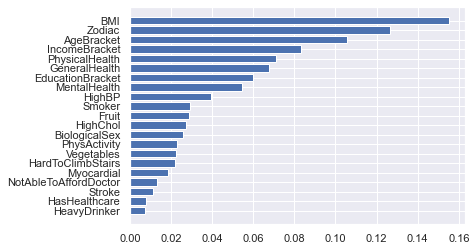

In [42]:
importances = rf_clf.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

## Section 4.3.2 `RandomForestClasifier()` Permutation Importance

In using the `eli5` package `PermutationImportance` we are able to do the same as the `sklearn` package, by permuting every feature and determining the importance of each feature by the effect it has on the model. As previously, the rows of every feature is shuffled and cross validate over 5-fold, and determine the features attributed to the largest drop in performance (which we will determine as most important) and the features attributed to the largest boost in performance (attributed as the least).

In [43]:
perm = PermutationImportance(estimator=rf_clf, random_state=1234)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0060 ± 0.0010,BMI
0.0048 ± 0.0009,GeneralHealth
0.0024 ± 0.0005,HighChol
0.0013 ± 0.0008,AgeBracket
0.0013 ± 0.0007,HighBP
0.0007 ± 0.0005,Myocardial
0.0005 ± 0.0001,HeavyDrinker
0.0004 ± 0.0005,HardToClimbStairs
0.0003 ± 0.0003,Smoker
0.0003 ± 0.0007,IncomeBracket


## Section 4.4 `RandomForestClassifier()` Confusion Matrix

Below we plot the confusion matrix for the logistic regression we just created.

This was done using the `sklearn` package `plot_confusion_matrix`.

No other alternative method seemed plausible, and a confusion matrix was plotted to show Predicted Labels against True Labels and therefore shows the correct/incorrect predicted values broken down by class.

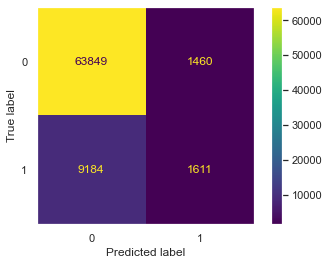

In [38]:
metrics.plot_confusion_matrix(estimator = rf_clf, X = X_test, y_true = y_test)
plt.grid(False)

## Section 4.5 `RandomForestClassifier()` AUC ROC

Below we calculate the AUR ROC as well as the accompanying graph of the full logistic regression model using the `sklearn` package and `RocCurveDisplay` to do so.

This was done to fulfill the requirement set forth in the Spec Sheet as well as to show the classification capability of our model to distinguish between $TPR = \frac{TP}{TP + TN}$ and $FPR = 1 - \frac{TN}{TN + FP} = \frac{FP}{FP + TN}$. 

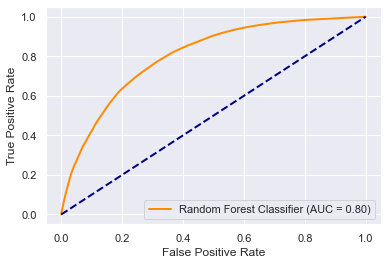

In [39]:
fpr, tpr, thresh = metrics.roc_curve(y_true=y_test, y_score=rfclf_proba, pos_label=1)
randforest_auc = metrics.auc(x=fpr, y=tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=randforest_auc,
                                  estimator_name='Random Forest Classifier')

display.plot(color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

## Section 4.6 `RandomForestClassifier()` Test Accuracy Scores

Below we show the `accuracy`, `precision`, `recall`, and `f1` scores found using `accuracy_score` and `precision_recall_fscore_support` all from `sklearn`.

This was done to determine the predictive capability against false positives and false negatives in the model (by accounting for model imbalance) of output classes by taking the harmonic mean of percision and recall.

In [40]:
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=rfclf_pred)
others = metrics.precision_recall_fscore_support(y_true=y_test, y_pred=rfclf_pred, average='binary')

adaboost_metrics =  {'accuracy': accuracy,
                     'precision': others[0],
                     'recall': others[1],
                     'f1': others[2]}

adaboost_metrics

{'accuracy': 0.8601387574897509,
 'precision': 0.524584825789645,
 'recall': 0.149235757295044,
 'f1': 0.2323669407183038}

## Section 4.7 Results & Discussion

Interpreting above, we can see that in the findings for our Random Forest Classifier model,

* Accuracy = 0.860139

* The single, individual predictor with the highest `PermutationImportance = 0.0060 ± 0.0010` is `BMI`

* The single, individual predictor with the highest `feature_importances_` importance (highest gini-impurity decrease) is `BMI`

* I also included a f1 score to highlight the ability to predict false positives and false negatives from the imbalanced data (shown in §0.6) which was 0.23236694

* Lastly, the AUR ROC for the entire model is around 0.80 for the test set, meaning the logistic classifier is better at discriminating between postive and negative classes than a random choice of classes (greater than 0.5 but not by much).

I then interpret the outputs as:

* From the accuracy and f1 scores, we see that our model predicts around 0.86 of all classes accurately, but from the f1 that the model is less robust in predicting in terms of the biased number of classes (such as in this dataset).

* From `PermutationImportance` we see that, by shuffling the indices of each feature column and repeating this 5-fold for each column, we obtain `BMI` as the most important (best) predictor. We will not be using gini-impurity decrease implementation of best predictor (`feature_importances_`) which still makes it out that `BMI` is the best predictor. Disregarding gini-importance methods (as stated previously) I will use `PermutationImporatance` finding that `BMI` is the best predictor in the `RandomForestClassifier()` model.

* The AUC of the entire model is plotted and stated previously (§1.5). At 0.80, it is able to better distinguish true positives and true negatives than random guessing.

# Question 5

Build a model using adaBoost. Doing so: What is the best predictor of diabetes and what is the AUC of this model?

## Answer

## Section 5.0 `AdaBoostClassifier()` Train-Test Split to Classifier

Accordingly with previous questions, we initiate a `train_test_split` with `test_size = 0.3` and `random_state = 1234`to cross validate results, and ensure predictive capability in action

In [32]:
X = df.loc[:, 'HighBP':]
y = label

print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

Shape of X:  (253680, 21)
Shape of y:  (253680, 1)


## Section 5.1 `AdaBoostClassifier()` Initialization and Fitting

Initialize and fit the `AdaBoostClassifier` to the data then calculate the probabilities of each `X_test` sample and class predictions for that test set.

This was done to create the model, and make it posible to make the model useful through prediction.

In [34]:
adaboost_clf = ensemble.AdaBoostClassifier()
adaboost_clf.fit(X_train, y_train)

adaboostclf_proba = adaboost_clf.predict_proba(X_test)[:,1]
adaboostclf_pred = adaboost_clf.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Section 5.2 `AdaBoostClassifier()` Tree Graph Using Graphviz

Create tree-graph and save as PDF. This was done initially to provide imagery for the output, but in retrospect became a nuisance due to the large format (22 predictors) of the output image and was not used.

In [ ]:
dot_data = tree.export_graphviz(adaboost_clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render('diabetes_adaboost')

In [ ]:
dot_data = tree.export_graphviz(adaboost_clf, out_file=None, 
                                feature_names=X.columns,  
                                class_names=y.columns[0],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Section 5.3.1 `AdaBoostClassifier()` Feature Importance

Below we used the `feature_importances_` attribute of the `AdaBoostClassifier()` class to determine the importance of features.

This was done to show the accumulation of impurity decrease with each successive node layer.

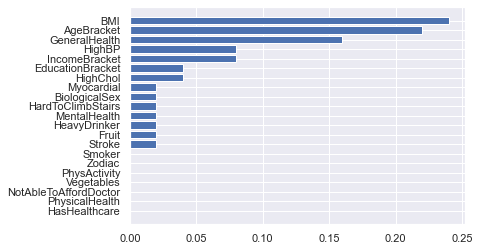

In [35]:
importances = adaboost_clf.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

## Section 5.3.2 `RandomForestClasifier()` Permutation Importance

In using the `eli5` package `PermutationImportance` we are able to do the same as the `sklearn` package, by permuting every feature and determining the importance of each feature by the effect it has on the model. As previously, the rows of every feature is shuffled and cross validate over 5-fold, and determine the features attributed to the largest drop in performance (which we will determine as most important) and the features attributed to the largest boost in performance (attributed as the least).

In [36]:
start = time.time()
perm = PermutationImportance(estimator=adaboost_clf, random_state=1234)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())
end=time.time()

print(f'Time elapsed: {end-start}')

Weight,Feature
0.0078 ± 0.0012,BMI
0.0046 ± 0.0007,GeneralHealth
0.0024 ± 0.0005,AgeBracket
0.0014 ± 0.0007,HighBP
0.0014 ± 0.0001,HighChol
0.0004 ± 0.0004,BiologicalSex
0.0003 ± 0.0004,HeavyDrinker
0.0001 ± 0.0001,Stroke
0 ± 0.0000,HasHealthcare
0 ± 0.0000,PhysicalHealth


## Section 5.4 `AdaBoostClassifier()` Confusion Matrix

Below we plot the confusion matrix for the logistic regression we just created.

This was done using the `sklearn` package `plot_confusion_matrix`.

No other alternative method seemed plausible, and a confusion matrix was plotted to show Predicted Labels against True Labels and therefore shows the correct/incorrect predicted values broken down by class.

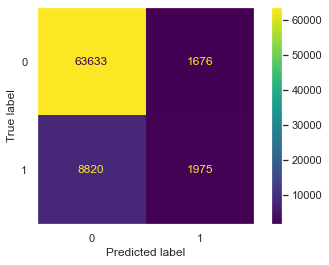

In [37]:
metrics.plot_confusion_matrix(estimator = adaboost_clf, X = X_test, y_true = y_test)
plt.grid(False)

## Section 5.5 `AdaBoostClassifier()` AUC ROC

Below we calculate the AUR ROC as well as the accompanying graph of the full logistic regression model using the `sklearn` package and `RocCurveDisplay` to do so.

This was done to fulfill the requirement set forth in the Spec Sheet as well as to show the classification capability of our model to distinguish between $TPR = \frac{TP}{TP + TN}$ and $FPR = 1 - \frac{TN}{TN + FP} = \frac{FP}{FP + TN}$. 

0.8210730162652649


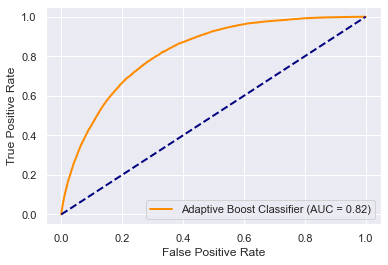

In [38]:
fpr, tpr, thresh = metrics.roc_curve(y_true=y_test, y_score=adaboostclf_proba, pos_label=1)
adaboost_auc = metrics.auc(x=fpr, y=tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=adaboost_auc,
                                  estimator_name='Adaptive Boost Classifier')

print(adaboost_auc)
display.plot(color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

## Section 5.6 `AdaBoostClassifier()` Test Accuracy Scores

Below we show the `accuracy`, `precision`, `recall`, and `f1` scores found using `accuracy_score` and `precision_recall_fscore_support` all from `sklearn`.

This was done to determine the predictive capability against false positives and false negatives in the model (by accounting for model imbalance) of output classes by taking the harmonic mean of percision and recall.

In [39]:
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=adaboostclf_pred)
others = metrics.precision_recall_fscore_support(y_true=y_test, y_pred=adaboostclf_pred, average='binary')

adaboost_metrics =  {'accuracy': accuracy,
                     'precision': others[0],
                     'recall': others[1],
                     'f1': others[2]}

adaboost_metrics

{'accuracy': 0.8620834647324713,
 'precision': 0.5409476855655985,
 'recall': 0.18295507179249654,
 'f1': 0.2734320919285616}

## Section 5.7 Results & Discussion

Interpreting above, we can see that in the findings for our Adaptive Boost Classifier model,

* Accuracy = 0.86208346

* The single, individual predictor with the highest `PermutationImportance = 0.0078 ± 0.0012` is `BMI`

* The single, individual predictor with the highest `feature_importances_` importance (highest gini-impurity decrease) is `BMI`

* I also included a f1 score to highlight the ability to predict false positives and false negatives from the imbalanced data (shown in §0.6) which was 0.273432

* Lastly, the AUR ROC for the entire model is around 0.82 for the test set, meaning the logistic classifier is better at discriminating between postive and negative classes than a random choice of classes (greater than 0.5).

I then interpret the outputs as:

* From the accuracy and f1 scores, we see that our model predicts around 0.86 of all classes accurately, but from the f1 that the model is less robust in predicting in terms of the biased number of classes (such as in this dataset).

* From `PermutationImportance` we see that, by shuffling the indices of each feature column and repeating this 5-fold for each column, we obtain `BMI` as the most important (best) predictor. We will not be using gini-impurity decrease implementation of best predictor (`feature_importances_`) which still makes it out that `BMI` is the best predictor. Disregarding gini-importance methods (as stated previously) I will use `PermutationImporatance` finding that `BMI` is the best predictor in the `RandomForestClassifier()` model.

* The AUC of the entire model is plotted and stated previously (§1.5). At 0.82107, it is able to better distinguish true positives and true negatives than random guessing.

# Question A

Which of these 5 models is the best to predict diabetes in this dataset?

## Answer

Looking at the AUC ROC scores for all of the models, along with corroborating the accuracy and F1 scores, we see that the `AdaBoostClassifier()` model, with `AUC = 0.8210730162652649` is the best model. The method of using AUC ROC to determine the most efficate model is due to the classification nature of the problem at hand, requiring determination of models that are representative, and not solely discriminative, selecting for models that are above random chance.

# Question B

Tell us something interesting about this dataset that is not already covered by the questions above and that is not obvious.

## Answer

`HasHealthcare` has a negative correlation (although not extreme in magnitude) with `BMI` (at `-0.0184707866`). This is perhaps due to adverse selection in insurance/healthcare, whereby consumers would knowingly engage in unsafe/unhealthy activies while having a sort of protection/recompense. Here we test for this by running One-way Kolmorgorov-Smirnov test between all samples that have `HasHealthcare == 1` (specific to the `BMI` feature) against all converse samples (`HasHealthcare == 0`).

Using `pandas` and the `scipy.stats` libraries, I first extracted all the rows of `df` where `'HasHealthcare' == 1` and `'HasHealthcare' == 0` into separate dataframes, and ran a `alternative: 'greater'` KS-test where `data1: yes_healthcare` and `data2: no_healthcare`.

In [7]:
yes_healthcare = df.loc[(df['HasHealthcare'] == 1), 'BMI']
no_healthcare = df.loc[(df['HasHealthcare'] == 0), 'BMI']

D_stat, p_value = st.ks_2samp(data1=yes_healthcare, data2=no_healthcare, alternative='greater')

print(f'D-statistic: {D_stat}, p-value: {p_value}')

D-statistic: 0.032959471374626736, p-value: 7.033128192087239e-12


From the analysis preceeding, we find that, with a p-value less than 0.05, we can reject the null hypothesis that `no_healthcare` ($G(x)$) is less than or equal to `yes_healthcare` ($F(x)$) in favor of the alternative that $F(x) > G(x)$ for some $x$. Further studies would need to be conducted to determine whether adverse selection is at play for deliberate misnagement of health due to having healthcare. For now, we cannot rule out that adverse selection is not in play with the samples in this dataset.

# Citations

&emsp;&emsp;[1] <span id="fn1">https://builtin.com/data-science/when-and-why-standardize-your-data</span>

&emsp;&emsp;[2] <span id="fn2">https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be</span>

&emsp;&emsp;[3] <span id="fn3">https://towardsdatascience.com/5x-faster-scikit-learn-parameter-tuning-in-5-lines-of-code-be6bdd21833c</span>

&emsp;&emsp;[4] <span id="fn4">https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html</span>

&emsp;&emsp;[5] <span id="fn5">https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance</span>

&emsp;&emsp;[6] <span id="fn6">https://graphviz.org/download/</span>

# Appendix

## Appendix 8.1 SVM Code
Code for using Scikit-Learn Ray-Tune to find optimal hyperparameters through searching over `C`, `gamma`, `degree`, and `kernel` choices.

In the next block, the tuned hyperparameters are used to instantiate the model

# **DO NOT** run this code block again, this is the fitting of the `SVC()` and takes more than two days on **TWO** GPU's

Using the mostly-finished run of hyperparameter search below (implemented through Ray-Tune/SKLearn[<sup>[3]</sup>](#fn3)), we estimate the given hyperparameters and hypotehsize that using a `kernel` of `rbf` would be best, with a `C` of 1.2560099135025111 and `gamma` of 0.004521554769370678.

In [12]:
param_grid = {'C': tune.loguniform(1e-3, 1e+2), # Check hyperparameters
              'gamma': tune.loguniform(1e-3, 1e+1),
              'degree': Integer(1,3),
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
             }

opt_SVC = TuneSearchCV(estimator=SVC(), param_distributions=param_grid, refit=True, verbose=1, n_jobs=-1, n_trials=1,
                           use_gpu=True, search_optimization='random', return_train_score=True)

start = time.time()
opt_SVC.fit(X_train, y_train) ## Commented out due to running Ray-Tune and already finging the optimal hyperparameters
end = time.time()

print("Tune RandomSearch Fit Time:", end - start)

Tune RandomSearch Fit Time: 0.0


In [ ]:
opt_SVC = SVC(C=1.2560099135025111, kernel='rbf', gamma=0.004521554769370678, probability=True)
opt_SVC.fit(X_train, y_train)

## Appendix 8.2 Healthcare & Diabetes
Debunked code relating Diabetes and Healthcare in adversarial selection

In [18]:
X = df.loc[(df['HasHealthcare'] == 1), 'HighBP':]
y = df.loc[(df['HasHealthcare'] == 1), 'Diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

ols = LinearRegression().fit(X_train, y_train)

ols_score = ols.score(X_test, y_test)
ols_predict = ols.predict(X_test)

ols_rmse = metrics.mean_squared_error(squared=False, y_true=y_test, y_pred=ols_predict)

In [19]:
print(f'R^2: {ols_score}')
print(f'RMSE: {ols_rmse}')

R^2: 0.1655691496405396
RMSE: 0.31840914594974606


In [20]:
X = df.loc[(df['HasHealthcare'] == 0), 'HighBP':]
y = df.loc[(df['HasHealthcare'] == 0), 'Diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

ols = LinearRegression().fit(X_train, y_train)

ols_score = ols.score(X_test, y_test)
ols_predict = ols.predict(X_test)

ols_rmse = metrics.mean_squared_error(squared=False, y_true=y_test, y_pred=ols_predict)

In [21]:
print(f'R^2: {ols_score}')
print(f'RMSE: {ols_rmse}')

R^2: 0.15519385596916202
RMSE: 0.29067772405862025


We can see from the $R^{2}$ and $RMSE$ of both models that this is unsubstantiated, that each measure of error are both similar, and insignifigcant. Specifically, for the $R^{2}$ of each model, the variance explained is less than 17% and 16% respectively.